# Semana 2, tarea 10

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# (Opcional) post-hoc Dunn con corrección de Holm
try:
    import scikit_posthocs as sp
    HAS_POSTHOC = True
except Exception:
    HAS_POSTHOC = False

sns.set_theme(style="whitegrid", context="talk")

In [2]:
def cm(w, h):
    return (w/2.54, h/2.54)

def first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    raise ValueError(f"No encontré ninguna de estas columnas: {candidates}")

def kruskal_for_var(df, value_col, group_col, min_n_per_group=2, save_prefix=None, outdir="fig_kruskal", save=True):
    dat = df[[value_col, group_col]].dropna().copy()
    dat[group_col] = dat[group_col].astype(str).str.strip()

    # Filtrar grupos con suficiente tamaño
    counts = dat[group_col].value_counts()
    keep_groups = counts[counts >= min_n_per_group].index.tolist()
    dat = dat[dat[group_col].isin(keep_groups)]

    k_groups = dat[group_col].nunique()
    if k_groups < 2:
        raise ValueError(f"'{group_col}' necesita ≥2 grupos con al menos {min_n_per_group} datos. "
                         f"Grupos válidos: {keep_groups}")

    # Preparar listas por grupo para kruskal
    samples = [dat.loc[dat[group_col] == g, value_col].to_numpy() for g in keep_groups]

    # Kruskal-Wallis
    stat, p = kruskal(*samples)

    print(f"\n=== {value_col} ~ {group_col} ===")
    print(f"Grupos ({k_groups}): {keep_groups}")
    print("Tamaños por grupo:")
    for g in keep_groups:
        print(f" - {g}: n={ (dat[group_col]==g).sum() }")
    print(f"Kruskal-Wallis H={stat:.3f}, p-valor={p:.4f}")

    # Boxplot por grupo
    plt.figure(figsize=cm(22, 14), dpi=300)
    order = keep_groups  # puedes ordenar por mediana si lo prefieres
    sns.boxplot(
        data=dat, x=group_col, y=value_col, order=order,
        palette="Set2", showfliers=False
    )
    sns.stripplot(
        data=dat, x=group_col, y=value_col, order=order,
        alpha=0.6, color=".25", size=3.5, jitter=0.25
    )
    plt.title(f"{value_col} por {group_col}\nKruskal–Wallis H={stat:.3f}, p={p:.3g}")
    plt.xlabel(group_col)
    plt.ylabel(value_col)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    if save and save_prefix:
        os.makedirs(outdir, exist_ok=True)
        plt.savefig(os.path.join(outdir, f"{save_prefix}_{value_col}_box_by_{group_col}.png"),
                    dpi=300, bbox_inches="tight")
    plt.show()

    # Post-hoc Dunn (opcional)
    if HAS_POSTHOC:
        try:
            # scikit-posthocs espera datos "largos"
            dunn = sp.posthoc_dunn(dat, val_col=value_col, group_col=group_col, p_adjust="holm")
            print("\nPost-hoc Dunn (p-ajustada Holm):")
            print(dunn.round(4))
            if save and save_prefix:
                dunn.to_csv(os.path.join(outdir, f"{save_prefix}_{value_col}_dunn_holm.csv"), index=True)
        except Exception as e:
            print(f"(Aviso) No se pudo calcular Dunn post-hoc: {e}")
    else:
        print("(Nota) scikit-posthocs no está instalado; omitiendo post-hoc Dunn.")
        print(">>> Para habilitarlo: pip install scikit-posthocs")


In [ ]:
CSV_PATH   = "Terminos_lagoon_TA_DIC_2023_RawData.csv"   
GROUP_COL  = "estuary"     
SAVE_FIGS  = True
OUTDIR     = "fig_kruskal"

# Candidatos de nombres de columnas
CANDIDATES_DIC  = ["dic_micromol_kg"]
CANDIDATES_TEMP = ["temp_c"]

Columnas detectadas:
 - DIC:  dic_micromol_kg
 - TEMP: temp_c

=== dic_micromol_kg ~ estuary ===
Grupos (2): ['Palizada', 'Candelaria']
Tamaños por grupo:
 - Palizada: n=54
 - Candelaria: n=52
Kruskal-Wallis H=1.770, p-valor=0.1834


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3448\2031948173.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


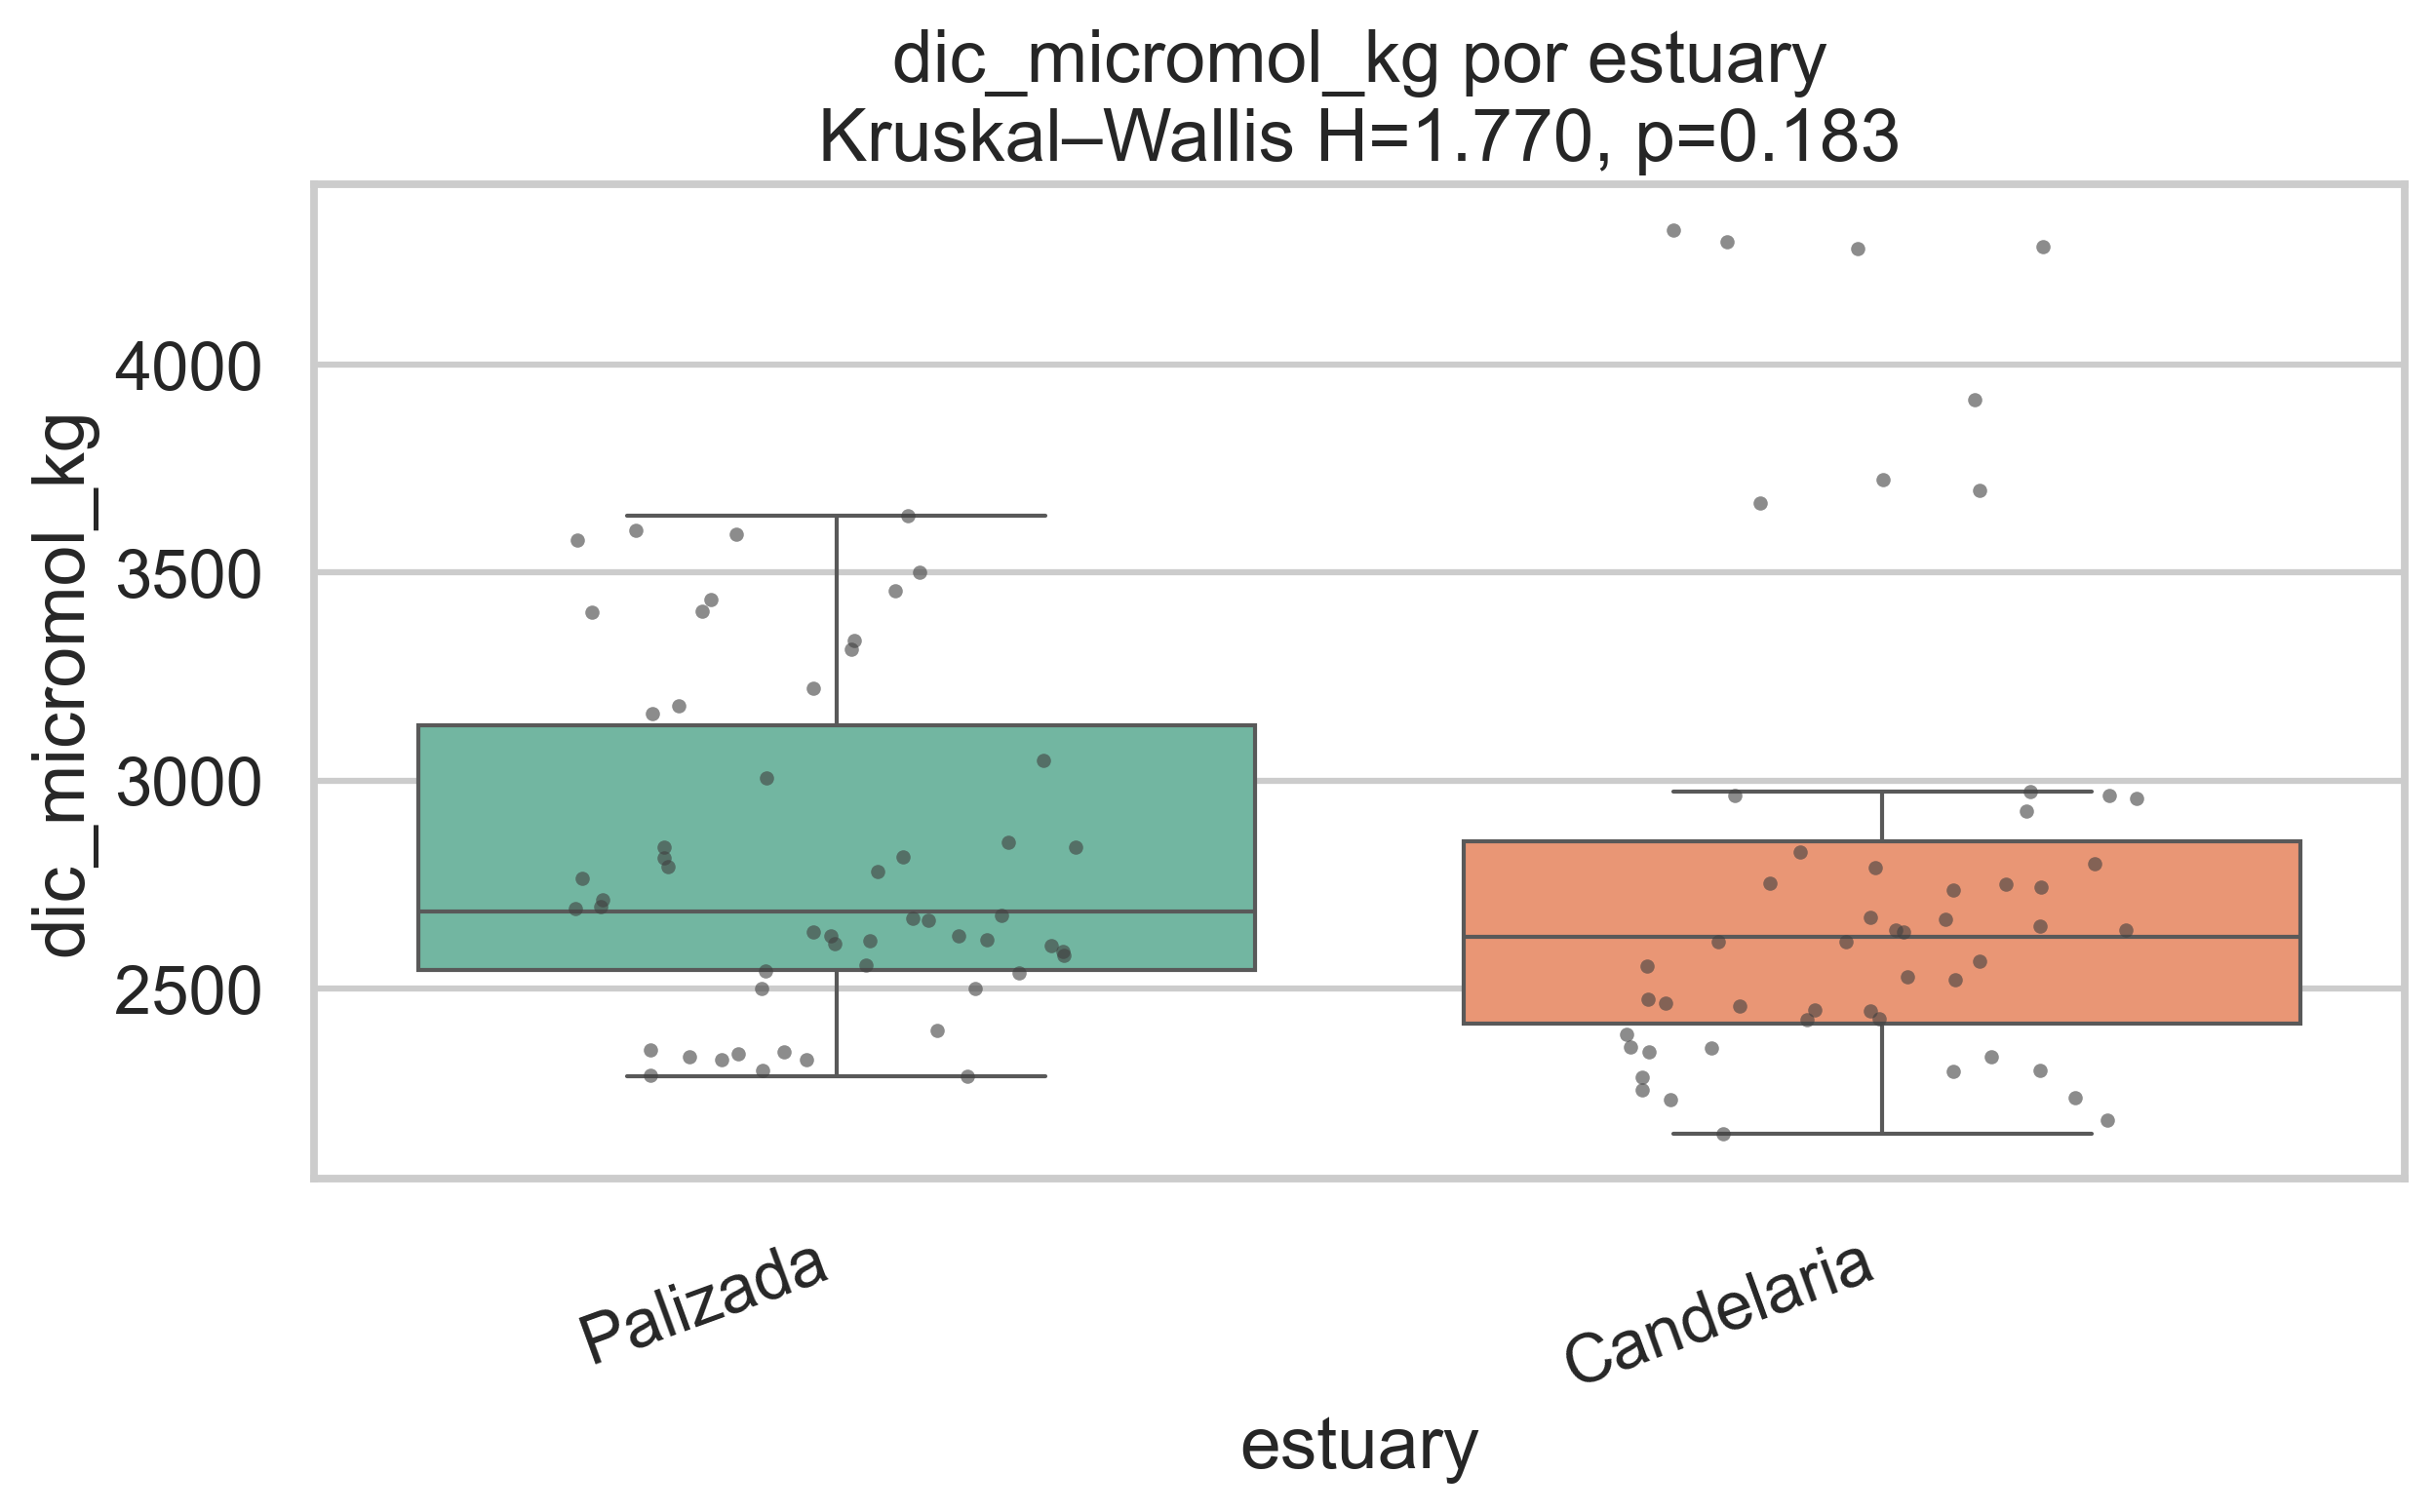


Post-hoc Dunn (p-ajustada Holm):
            Candelaria  Palizada
Candelaria      1.0000    0.1834
Palizada        0.1834    1.0000

=== temp_c ~ estuary ===
Grupos (2): ['Palizada', 'Candelaria']
Tamaños por grupo:
 - Palizada: n=54
 - Candelaria: n=52
Kruskal-Wallis H=2.253, p-valor=0.1334


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3448\2031948173.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


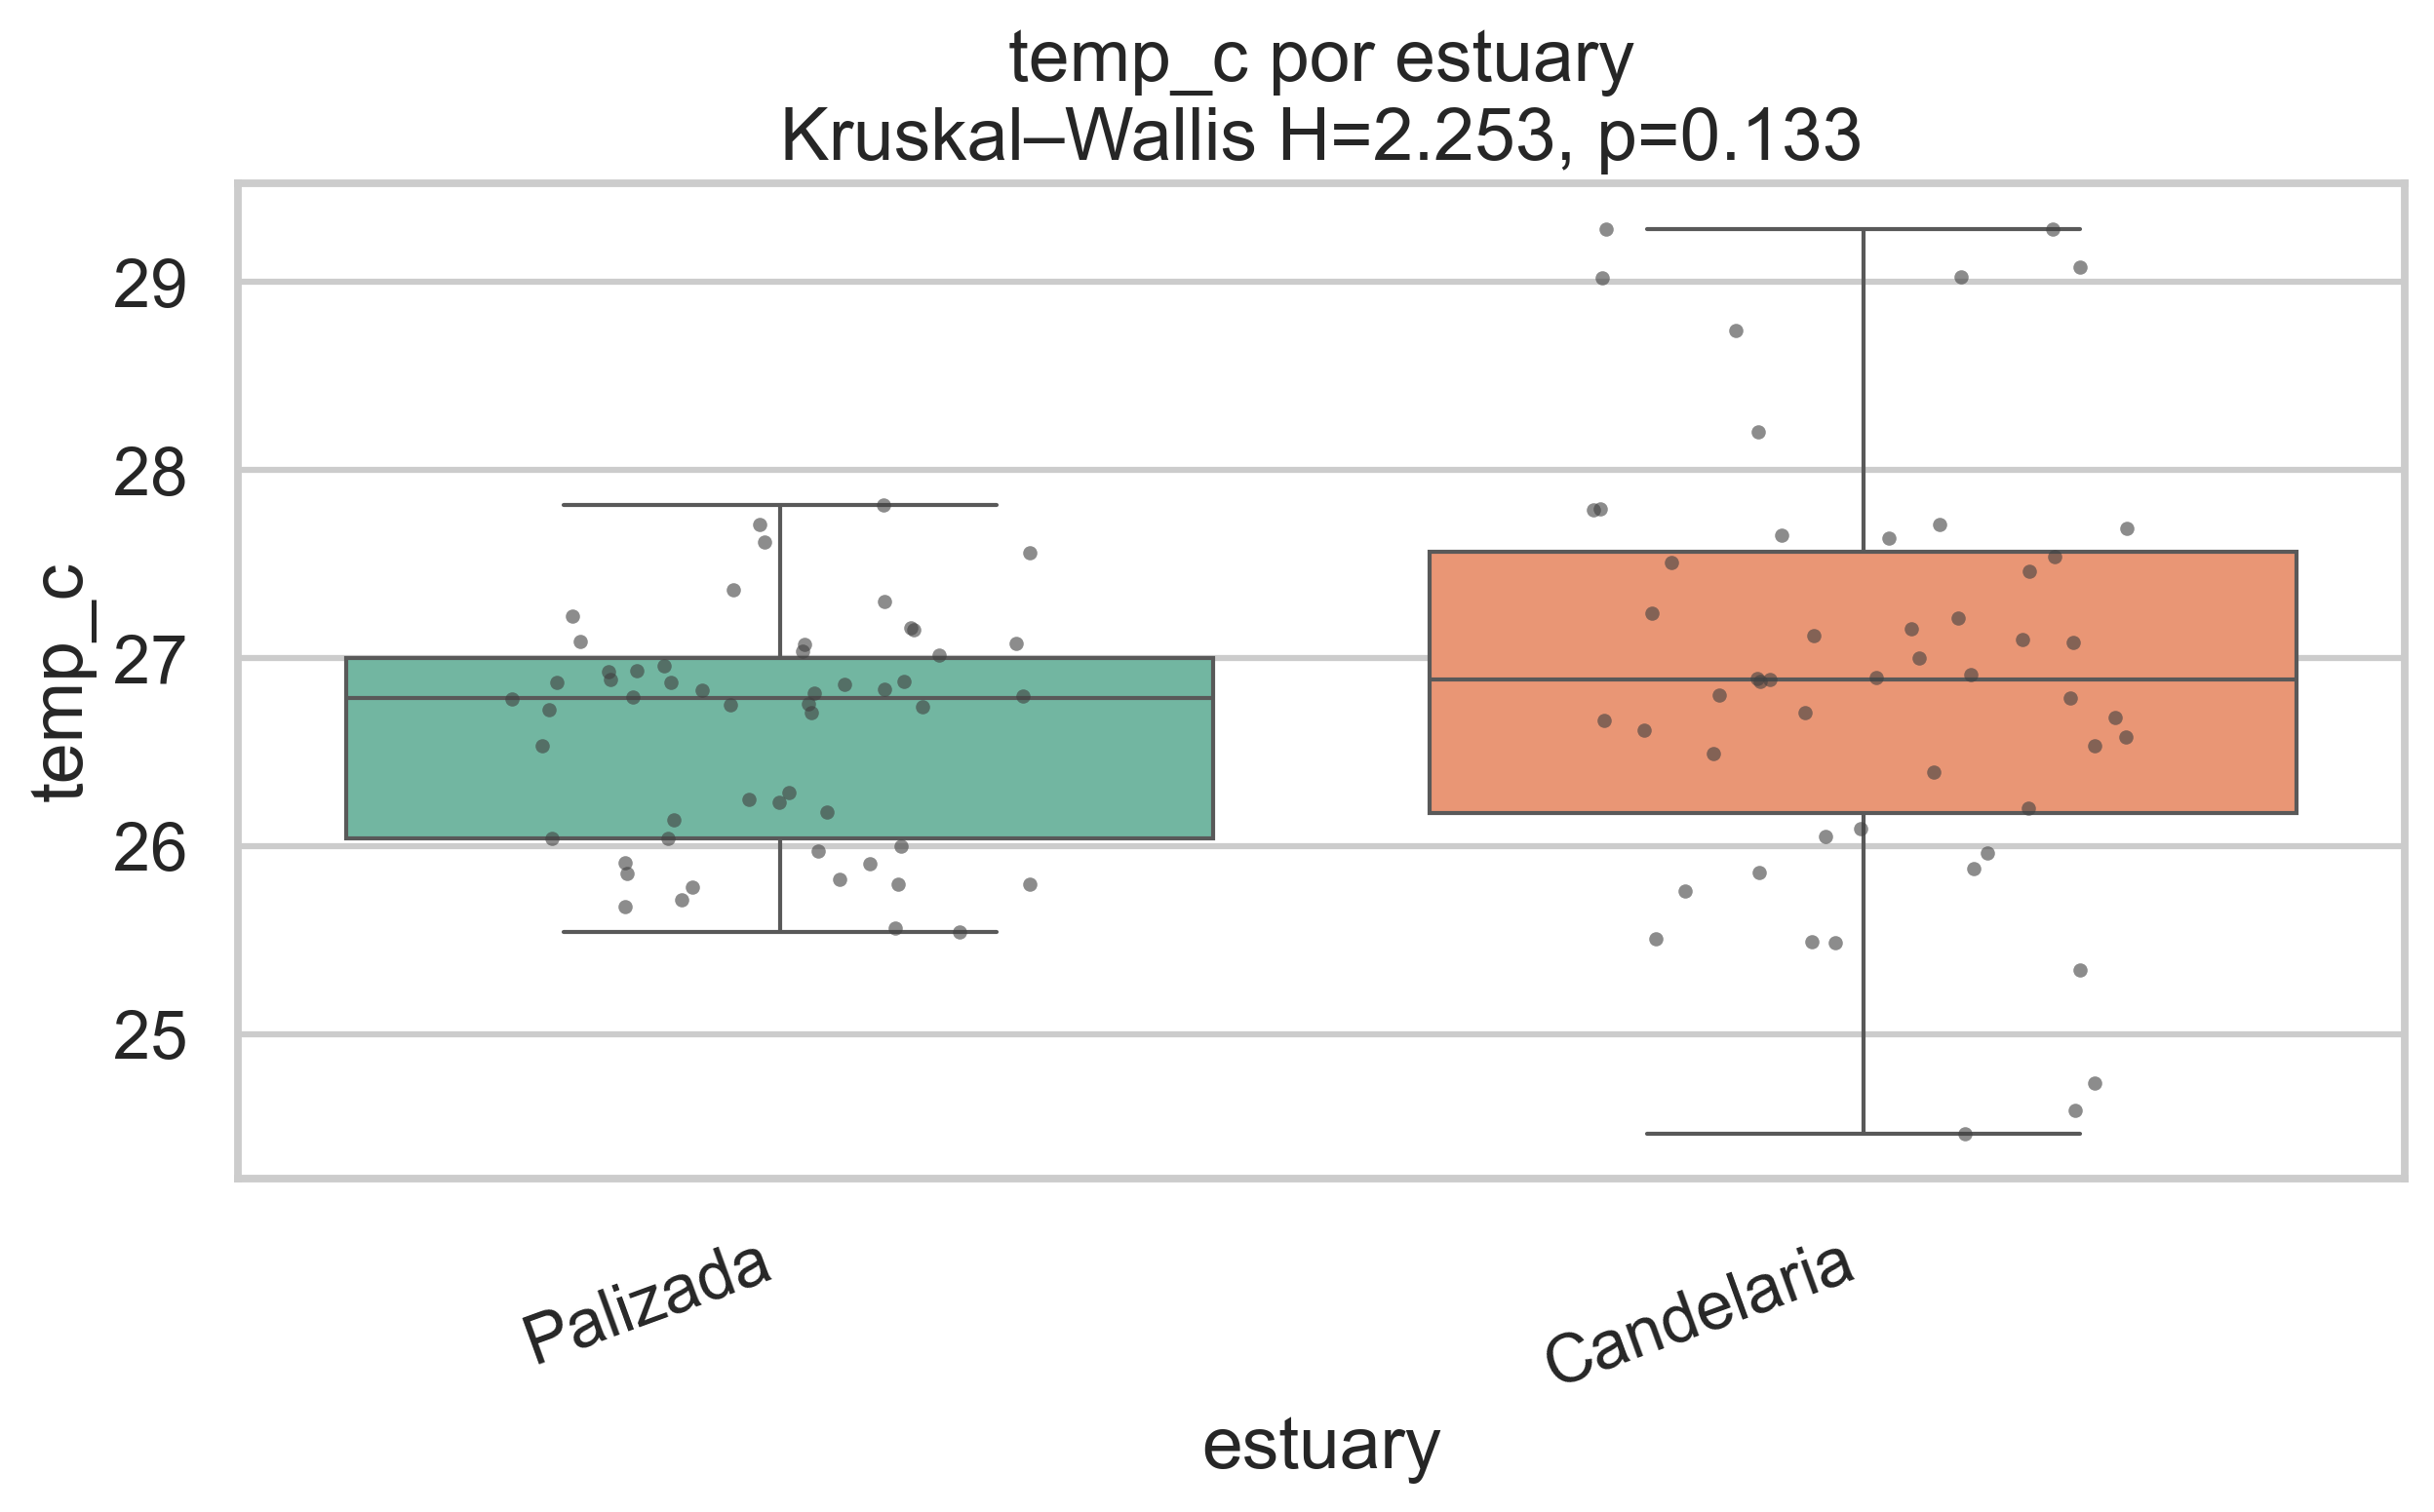


Post-hoc Dunn (p-ajustada Holm):
            Candelaria  Palizada
Candelaria      1.0000    0.1334
Palizada        0.1334    1.0000


In [4]:
if __name__ == "__main__":
    # Leer datos
    df = pd.read_csv(CSV_PATH)
    cols = df.columns.tolist()

    # Detectar columnas de interés
    DIC_COL  = first_existing(cols, CANDIDATES_DIC)
    TEMP_COL = first_existing(cols, CANDIDATES_TEMP)

    print("Columnas detectadas:")
    print(f" - DIC:  {DIC_COL}")
    print(f" - TEMP: {TEMP_COL}")
    if GROUP_COL not in cols:
        raise ValueError(f"No encontré '{GROUP_COL}' en el CSV. Columnas disponibles: {cols}")

    # Ejecutar Kruskal-Wallis y boxplots
    kruskal_for_var(df, DIC_COL,  GROUP_COL, min_n_per_group=2,
                    save_prefix="KW", outdir=OUTDIR, save=SAVE_FIGS)
    kruskal_for_var(df, TEMP_COL, GROUP_COL, min_n_per_group=2,
                    save_prefix="KW", outdir=OUTDIR, save=SAVE_FIGS)

## Para el carbono inorgánico disuelto (DIC)
Se compararon los dos estudarios: Palzada y Candelaria
-Kruskal_Wallis: H = 1.770 y p = 0.1834
El valor de p es mayor a 0.05, entonces no hay diferencias estadísticamente significativas en la concnetración de DIC entre ambos estuarios
-Prueba post_hoc Dunn: p = 0.1834
Al ser mayor de 0.05, no hay diferencias nuevamente. 

## Para la temperatura 
-Kruskal_Wallis: H = 2.253 y p = 0.1334
No hay diferencias en la temperatura entre ambos estuarios-
-Prueba pos_hoc Dunn: p-ajustado = 0.1334
Sin diferencias. 
